In [1]:
import sys
sys.path.append("../")

from random import random
from math import pi
import numpy as np
from utils import Utils
import seaborn as sns
import pandas as pd
import os, json
from datetime import datetime
from matplotlib import pyplot as plt

In [2]:
# Definição da função objetivo - Função Rastrigin
def objectiveFunction(X):

    A = 10

    return A * 2 + sum([(x ** 2 - A * np.cos(2 * pi * x)) for x in X])

In [3]:
# Configurações da execução
execution = datetime.today().strftime("%Y%m%d%H%M")

# Definições do PSO
pop_size = 30
n_bits = 15
epochs = 100
x_interval = y_interval = [-10, 10]
inertial_weight = [0.4, 0.9]
acceleration_factor = [2, 2]

# Definições iwim_PSO
mutation_rate = 0.0175
population_after_mut = {}

# Inicialização das variáveis
population = {}
fitness = {}
pbest = {}
gbest = {}
pbest_fit = {}
gbest_fit = {}

# Acesso à funções gerais
functions = Utils(n_bits, x_interval[0], x_interval[1])

In [4]:
# Inicialização da população

velocity = []

for i in range(pop_size):

    ind_velocity = []

    for j in range(n_bits * 2):

        ind_velocity.append(random())

    velocity.append(ind_velocity)

x = functions.selectBit(velocity)

# Cálculo do fitness inicial

fit = []

for individual in x:

    solution = [functions.binToDec(individual[0:n_bits]), functions.binToDec(individual[n_bits:])]

    fit.append(objectiveFunction(solution))

population[0] = x
population_after_mut[0] = x
fitness[0] = fit
pbest[0] = x
pbest_fit[0] = fit
gbest[0] = x[fit.index(min(fit))]
gbest_fit[0] = min(fit)

In [5]:
iwim = [0] * pop_size

for iter in range(1, epochs + 1):

    # Atualiza o peso inercial
    w = inertial_weight[1] - ((inertial_weight[1] - inertial_weight[0]) * (iter / epochs))

    # Atualiza a velocidade
    for i in range(pop_size):

        ind_velocity = []

        for j in range(n_bits * 2):

            ind_velocity.append(
                (w * velocity[i][j]) + (acceleration_factor[0] * random() * (int(pbest[iter-1][i][j]) - int(x[i][j]))) + (acceleration_factor[1] * random() * (int(gbest[iter-1][j]) - int(x[i][j]))) 
            )
        
        velocity[i] = ind_velocity
    
    # Atualiza as posições das partículas
    x = functions.selectBit(velocity)

    # Atualiza o fitness
    fit = []
    
    for individual in x:

        solution = [functions.binToDec(individual[0:n_bits]), functions.binToDec(individual[n_bits:])]

        fit.append(objectiveFunction(solution))

    # Atualiza o Pbest
    pbest[iter] = []
    pbest_fit[iter] = []
    
    for i in range(pop_size):

        if fit[i] <= pbest_fit[iter-1][i]:

            pbest_fit[iter].append(fit[i])
            pbest[iter].append(x[i])
            iwim[i] = 0

        else:

            pbest_fit[iter].append(pbest_fit[iter-1][i])
            pbest[iter].append(pbest[iter-1][i])
            iwim[i] = iwim[i] + 1

    # Atualiza o Gbest
    if min(fit) <= gbest_fit[iter-1]:

        gbest_fit[iter] = min(fit)
        gbest[iter] = x[fit.index(min(fit))]
    
    else:

        gbest_fit[iter] = gbest_fit[iter-1]
        gbest[iter] = gbest[iter-1]
    
    # Salva a população da iteração e o fitness gerado
    population[iter] = x.copy()
    fitness[iter] = fit.copy()

    # Aplica mutação por iteração sem melhora
    for i in range(pop_size):

        if iwim[i] >= 3:

            x[i] = functions.mutate(x[i], mutation_rate)
    
    population_after_mut[iter] = x

In [6]:
# Dump dos resultados
if not os.path.exists("./Results"):
    os.mkdir("./Results")

os.mkdir("./Results/execution_{}".format(execution))
os.chdir("./Results/execution_{}".format(execution))

with open("population.json", "w") as f:
    json.dump(population, f)

with open("population_after_mut.json", "w") as f:
    json.dump(population_after_mut, f)

with open("population_fitness.json", "w") as f:
    json.dump(fitness, f)

with open("pbest_particles.json", "w") as f:
    json.dump(pbest, f)

with open("pbest_fitness.json", "w") as f:
    json.dump(pbest_fit, f)

with open("gbest_particles.json", "w") as f:
    json.dump(gbest, f)

with open("gbest_fitness.json", "w") as f:
    json.dump(gbest_fit, f)

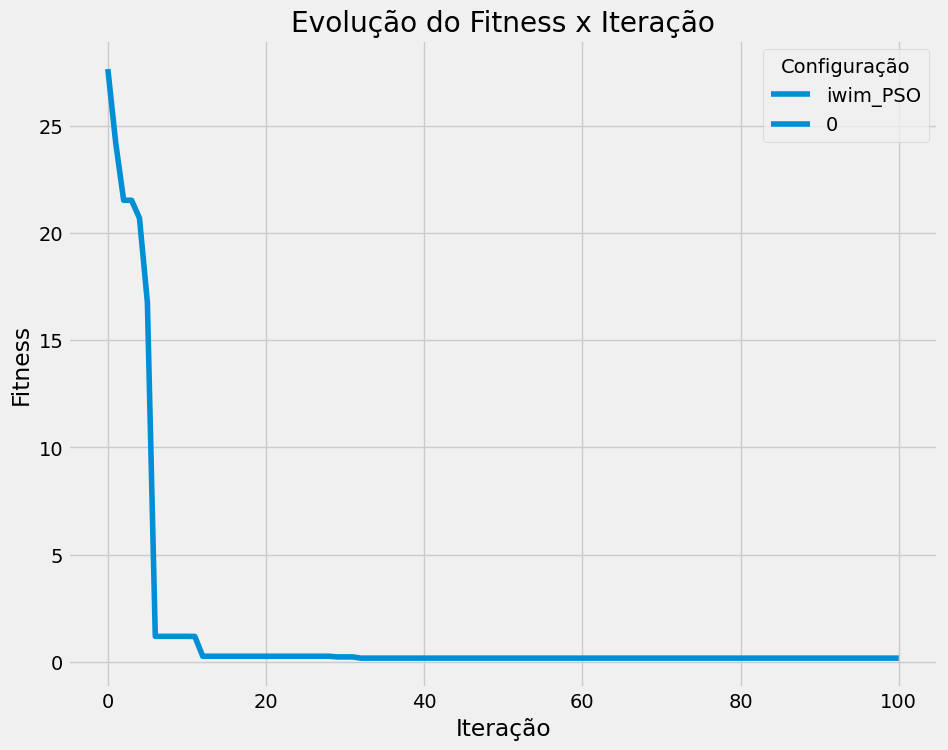

In [8]:
# Plot da evolução do fitness ao longo da execução 
plt.figure(figsize=(10, 8))
plt.style.use('fivethirtyeight')
fitness_evolution = pd.DataFrame(gbest_fit, index=[0])
sns.lineplot(data=fitness_evolution.transpose(), label="iwim_PSO")
plt.title("Evolução do Fitness x Iteração")
plt.legend(title='Configuração')
plt.xlabel("Iteração")
plt.ylabel("Fitness")
plt.savefig("./fitness_evolution.png".format(execution))    